In [4]:
import pandas as pd
import numpy as np

In [52]:
df = pd.read_csv("bank-full.csv", sep = ";")

In [6]:
df.head().T

,0,1,2,3,4
age,58,44,33,47,33
job,management,technician,entrepreneur,blue-collar,unknown
marital,married,single,married,married,single
education,tertiary,secondary,secondary,unknown,unknown
default,no,no,no,no,no
balance,2143,29,2,1506,1
housing,yes,yes,yes,yes,no
loan,no,no,yes,no,no
contact,unknown,unknown,unknown,unknown,unknown
day,5,5,5,5,5


In [53]:
cols = ["age", "job", "marital", "education", "balance", "housing", "contact", "day", "month", "duration", "campaign", "pdays", "previous", "poutcome", "y"]

In [54]:
df = df[cols]

In [55]:
df.y = (df.y == 'yes').astype(int)

### Split the data

In [9]:
from sklearn.model_selection import train_test_split

In [56]:
df_full_train, df_test = train_test_split(df, test_size = 0.2, random_state = 1)

In [57]:
df_train, df_val = train_test_split(df_full_train, test_size = 0.25, random_state = 1)

In [58]:
len(df_train), len(df_val), len(df_test)

(27126, 9042, 9043)

In [59]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [60]:
y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

In [61]:
y_test

array([0, 0, 0, ..., 0, 0, 1])

In [62]:
del df_train["y"]
del df_val["y"]
del df_test["y"]

## Question 1: ROC AUC feature importance

In [63]:
numeric = ['balance', 'day', 'duration', 'previous']

In [21]:
numeric

['balance', 'day', 'duration', 'previous']

In [64]:
from sklearn.metrics import roc_auc_score

In [65]:
for feature in numeric:
    # AUC for the 'balance' feature
    auc_balance = roc_auc_score(y_train, df_train[feature])
    print(f'AUC for {feature}: {auc_balance}')

AUC for balance: 0.5888313805382317
AUC for day: 0.474042117616092
AUC for duration: 0.8147002759670778
AUC for previous: 0.5985653242764153


## Question 2: Training the model

__One-hot encoding__

In [66]:
from sklearn.feature_extraction import DictVectorizer

In [67]:
train_dicts = df_train.to_dict(orient='records')

In [68]:
dv = DictVectorizer(sparse=False)

In [69]:
X_train = dv.fit_transform(train_dicts)

In [70]:
val_dicts = df_val.to_dict(orient='records')

In [71]:
X_val = dv.transform(val_dicts)

__Logistic regression__

In [72]:
from sklearn.linear_model import LogisticRegression

In [73]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [74]:
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

__The AUC of this model on the validation dataset (round to 3 digits)__

In [75]:
y_pred_val = model.predict_proba(X_val)[:, 1]

In [76]:
auc_pred_val = roc_auc_score(y_val, y_pred_val)
print(f'AUC for y_pred_val: {round(auc_pred_val,3)}')

AUC for y_pred_val: 0.9


## Question 3: Precision and Recall

In [108]:
scores = []

thresholds = np.linspace(0,1,101)

for t in thresholds:

    actual_pos = (y_val == 1)
    actual_neg = (y_val == 0)

    predict_pos = (y_pred >= t)
    predict_neg = (y_pred < t)

    tp = (actual_pos & predict_pos).sum()
    tn = (actual_neg & predict_neg).sum()

    fp = (actual_neg & predict_pos).sum()
    fn = (actual_pos & predict_neg).sum()

    scores.append((t, tp, fp, fn, tn))

In [101]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']

In [109]:
df_scores = pd.DataFrame(scores, columns=columns)

In [110]:
df_scores["precision"] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores["recall"] = df_scores.tp / (df_scores.tp + df_scores.fn)



In [111]:
df_scores

,threshold,tp,fp,fn,tn,precision,recall
0,0.00,1098,7944,0,0,0.121433,1.000000
1,0.01,1094,7004,4,940,0.135095,0.996357
2,0.02,1093,5789,5,2155,0.158820,0.995446
3,0.03,1087,4744,11,3200,0.186417,0.989982
4,0.04,1068,3800,30,4144,0.219392,0.972678
...,...,...,...,...,...,...,...
96,0.96,30,17,1068,7927,0.638298,0.027322
97,0.97,25,15,1073,7929,0.625000,0.022769
98,0.98,21,10,1077,7934,0.677419,0.019126
99,0.99,11,5,1087,7939,0.687500,0.010018


In [90]:
y_val

array([0, 0, 0, ..., 0, 0, 0])

In [84]:
from matplotlib import pyplot as plt

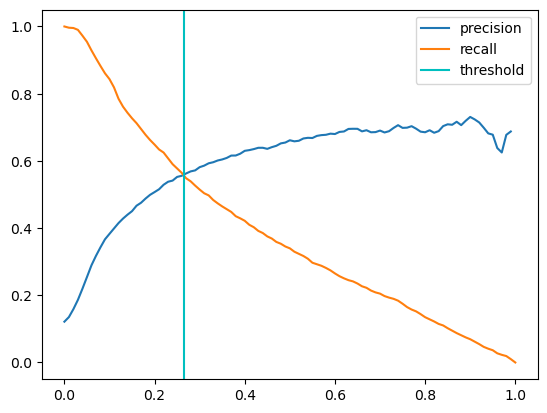

In [117]:
plt.plot(df_scores.threshold, df_scores["precision"], label = 'precision')
plt.plot(df_scores.threshold, df_scores["recall"], label = 'recall')
plt.axvline(x = 0.265, color = 'c', label = 'threshold')
plt.legend()
plt.show()

## Question 4: F1 score

In [118]:
df_scores["F1 score"] = 2* df_scores.precision * df_scores.recall / (df_scores.precision + df_scores.recall)

In [120]:
df_scores["F1 score"].idxmax()

22

In [121]:
df_scores["threshold"][22] 

0.22

## Question 5: 5-Fold CV

In [134]:
def train(df_train, y_train, C=1.0):
    dicts = df_train.to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

In [125]:
dv, model = train(df_train, y_train)

In [126]:
def predict(df, dv, model):
    dicts = df.to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [127]:
y_pred = predict(df_val, dv, model)

In [128]:
y_pred

array([0.02995567, 0.0231619 , 0.0207711 , ..., 0.24874242, 0.0021865 ,
       0.03779507])

In [129]:
from sklearn.model_selection import KFold

In [130]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [139]:
def calculate_std_mean_scores(C):
    scores = []
    
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
    
        y_train = df_train.y.values
        y_val = df_val.y.values
    
        del df_train["y"]
        del df_val["y"]  
    
        dv, model = train(df_train, y_train, C)
        y_pred = predict(df_val, dv, model)
    
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    print("std = {}, mean = {}".format(round(np.std(scores), 3), round(np.mean(scores), 3)))

In [138]:
print("std = {}, mean = {}".format(round(np.std(scores), 3), round(np.mean(scores), 3)))

std = 0.005, mean = 0.906


## Question 6: Hyperparameter Tuning

In [140]:
for c in [0.000001, 0.001, 1]:
    print("C = ", c)
    calculate_std_mean_scores(c)    

C =  1e-06
std = 0.009, mean = 0.701
C =  0.001
std = 0.007, mean = 0.861
C =  1
std = 0.005, mean = 0.906
